# **Отчёт о выполнеии итоговой работы курса "Big Data c нуля"**
***

**В качестве датасета используем данные условного онлайн-кинотеатра. У нас есть информация о пользователях, фильмах, а так же оценках, которые пользователи поставили тому или иному фильму. В рамках работы хотим провести исследование текущей ситуации и решить бизнес-кейс с
рекомендациями фильмов пользователям (очевидно, что не все пользователи смотрели все фильмы и нам нужно каким-то образом рекомендовать пользователю, что ему посмотреть следующим).**

In [7]:
from IPython.display import Image
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from IPython.display import display, HTML # Добавляем горизонтальный скроллинг
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as func

22/11/04 19:55:10 WARN Utils: Your hostname, sk27-HN-WX9X resolves to a loopback address: 127.0.1.1; using 192.168.43.50 instead (on interface wlp1s0)
22/11/04 19:55:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/04 19:55:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **I. Практика Google Sheets**

**[Файл Google Sheets part 1](https://docs.google.com/spreadsheets/d/1aCarj3NPrigd0eiFymsoPDAFMtslwe5Gz4tRWrtcUnc/edit?usp=sharing)**

### 1.1. Построить гистограмму количества пользователей в зависимости от их возраста

In [8]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vT6Js2tYd44E6gdxrWv1BWc-ChdeKVqtGlNhZ1KSTg3F1ANehETSWONcQRFS66VCa1EiLod-X0HwkWa/pubchart?oid=393050400&format=image',
              width = 1000))

### 1.2. Построить 2 графика, показывающих распределение людей по профессиям в зависимости от их пола

In [9]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vT6Js2tYd44E6gdxrWv1BWc-ChdeKVqtGlNhZ1KSTg3F1ANehETSWONcQRFS66VCa1EiLod-X0HwkWa/pubchart?oid=170614497&format=image',
              width = 1000))
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vT6Js2tYd44E6gdxrWv1BWc-ChdeKVqtGlNhZ1KSTg3F1ANehETSWONcQRFS66VCa1EiLod-X0HwkWa/pubchart?oid=718612998&format=image',
              width = 1000))

### 1.3. Построить график количества фильмов по жанрам

In [10]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vT6Js2tYd44E6gdxrWv1BWc-ChdeKVqtGlNhZ1KSTg3F1ANehETSWONcQRFS66VCa1EiLod-X0HwkWa/pubchart?oid=973061914&format=image',
              width = 1000))

### 1.4. Построить график количества фильмов по годам релиза

In [11]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vT6Js2tYd44E6gdxrWv1BWc-ChdeKVqtGlNhZ1KSTg3F1ANehETSWONcQRFS66VCa1EiLod-X0HwkWa/pubchart?oid=1908276093&format=image',
              width = 1000))

**[Файл Google Sheets part 2](https://docs.google.com/spreadsheets/d/1LD9NWJ-ttRyjmpn2hyHpwKEvfe1bDB_pWWA69tbefZE/edit?usp=sharing)**

### 1.5. Построить график количества оценок по месяцам и годам

In [12]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vTHTQwQG8lTflJJcBz0IsmbLDJlYWGGeqSs-vLBEY3QRFkE_MH-ynYXqhWuqnbksk5RYru8cSCM2-wj/pubchart?oid=1064242814&format=image',
              width = 1000))

### 1.6. Выявить top-5 самых активных пользователей (больше всего оценок) за последние 3 месяца
В этом задании возможно выявить пользователей, поставивших наибольшее количество оценок:
* за 3 месяца до отчётной даты (22 апреля 1998 г.);
* за три последних календарных месяца (февраль, март и апрель 1998 г.)

In [13]:
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vTHTQwQG8lTflJJcBz0IsmbLDJlYWGGeqSs-vLBEY3QRFkE_MH-ynYXqhWuqnbksk5RYru8cSCM2-wj/pubchart?oid=1404550327&format=image',
              width = 1000))
display(Image(url='https://docs.google.com/spreadsheets/d/e/2PACX-1vTHTQwQG8lTflJJcBz0IsmbLDJlYWGGeqSs-vLBEY3QRFkE_MH-ynYXqhWuqnbksk5RYru8cSCM2-wj/pubchart?oid=1850113119&format=image',
              width = 1000))

## **II. Практика Python**

### 2.1. Загрузите файлы по оценкам (ratings) и фильмам (movies) и создайте на их основе pandas-датафреймы

Загрузим и подготовим данные для дальнейшей работы с ними:

In [14]:
df_mov = pd.read_csv('/home/sk27/learning/BIG_DATA/bd_project_work/part_1/ml-100k/data/movies.csv', sep = '|')
df_mov['release_date'] = pd.to_datetime(df_mov['release_date']) # Преобразуем данные datatime
df_mov = df_mov.drop(['video_release_date', 'url'], axis = 1)

In [15]:
df_mov.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [16]:
df_mov.info() # Хорошие, годные данные.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   movie_id      1681 non-null   int64         
 1   movie_title   1681 non-null   object        
 2   release_date  1681 non-null   datetime64[ns]
 3   unknown       1681 non-null   int64         
 4   Action        1681 non-null   int64         
 5   Adventure     1681 non-null   int64         
 6   Animation     1681 non-null   int64         
 7   Children      1681 non-null   int64         
 8   Comedy        1681 non-null   int64         
 9   Crime         1681 non-null   int64         
 10  Documentary   1681 non-null   int64         
 11  Drama         1681 non-null   int64         
 12  Fantasy       1681 non-null   int64         
 13  Film_Noir     1681 non-null   int64         
 14  Horror        1681 non-null   int64         
 15  Musical       1681 non-null   int64   

In [17]:
df_rat = pd.read_csv('/home/sk27/learning/BIG_DATA/bd_project_work/part_1/ml-100k/data/rating.csv', sep = '\t', encoding = 'utf-8')

In [18]:
df_rat.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
df_rat.info() # Подготовка данных не требуется, у них и без того всё хорошо.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


### 2.2. Средствами pandas, используя dataframe ratings, найдите id пользователя, поставившего больше всего оценок

In [20]:
r = df_rat.groupby('user_id').count().sort_values(by='rating', ascending=False).iloc[:, -2].to_frame().reset_index().iloc[0, 0]
r # 'r' и есть id самого активного пользователя.

405

### 2.3. Оставьте в датафрейме ratings только те фильмы, который оценил данный пользователь

In [21]:
df_rating = df_rat[df_rat['user_id'] == r].reset_index().drop('index', axis = 1)
df_rating.head() # Сведения о тех самых фильмах.

,user_id,item_id,rating,timestamp
0,405,56,4,885544911
1,405,592,1,885548670
2,405,1582,1,885548670
3,405,171,1,885549544
4,405,580,1,885547447


### 2.4. Добавьте к датафрейму из задания 2.3 столбцы:
* По жанрам. Каждый столбец - это жанр. Единицу записываем, если фильм принадлежит данному жанру и 0 - если нет
* Cтолбцы с общим количеством оценок от всех пользователей на фильм и суммарной оценкой от всех пользователей

In [22]:
df_rat_sum=df_rat.groupby('item_id').sum().drop(['user_id', 'timestamp'], axis=1).rename(columns={'rating': 'rating_sum'}) # Сумма всех оценок
df_rat_count=df_rat.groupby('item_id').count().drop(['user_id', 'timestamp'], axis=1).rename(columns={'rating': 'rating_count'}) # Количество всех оценок
df_rating = df_rating.merge(df_mov, how='left', left_on='item_id', right_on='movie_id').merge(df_rat_sum, how='inner', left_on='item_id', right_on='item_id')\
.merge(df_rat_count, how='inner', left_on='item_id', right_on='item_id') # Приджойним данные о суммарной оценке и количеству оценок
df_rating['relase_year'] = (df_rating['release_date']).dt.year # Выделим из даты год релиза
df_rating=df_rating.drop(['user_id', 'movie_id', 'release_date', 'timestamp'], axis=1) # Удалим лишнее

In [23]:
df_rating.head()

,item_id,rating,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,rating_sum,rating_count,relase_year
0,56,4,Pulp Fiction (1994),0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1600,394,1994
1,592,1,True Crime (1995),0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,30,9,1995
2,1582,1,T-Men (1947),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1947
3,171,1,Delicatessen (1991),0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,252,65,1991
4,580,1,"Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,108,32,1995


In [24]:
df_rating.describe() # Атрибут "unknown" пуст (как в снегах розовый куст). Что ж, удалим и его.

,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,rating_sum,rating_count,relase_year
count,737.000000,737.000000,737.0,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,...,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000
mean,732.933514,1.834464,0.0,0.165536,0.099050,0.040706,0.104478,0.301221,0.055631,0.021710,...,0.032564,0.028494,0.149254,0.073270,0.134328,0.052917,0.028494,261.242877,71.725916,1988.089552
std,470.160223,1.345183,0.0,0.371916,0.298932,0.197741,0.306087,0.459100,0.229363,0.145833,...,0.177614,0.166492,0.356580,0.260756,0.341236,0.224020,0.166492,340.297551,84.519925,12.671009
min,2.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1931.000000
25%,381.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,11.000000,1988.000000
50%,668.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129.000000,40.000000,1994.000000
75%,1110.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,351.000000,101.000000,1995.000000
max,1592.000000,5.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2541.000000,583.000000,2022.000000


In [25]:
df_rating=df_rating.drop(['unknown'], axis=1)

In [26]:
df_rating.info() # Данные готовы для построения модели.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_id       737 non-null    int64 
 1   rating        737 non-null    int64 
 2   movie_title   737 non-null    object
 3   Action        737 non-null    int64 
 4   Adventure     737 non-null    int64 
 5   Animation     737 non-null    int64 
 6   Children      737 non-null    int64 
 7   Comedy        737 non-null    int64 
 8   Crime         737 non-null    int64 
 9   Documentary   737 non-null    int64 
 10  Drama         737 non-null    int64 
 11  Fantasy       737 non-null    int64 
 12  Film_Noir     737 non-null    int64 
 13  Horror        737 non-null    int64 
 14  Musical       737 non-null    int64 
 15  Mystery       737 non-null    int64 
 16  Romance       737 non-null    int64 
 17  Sci_Fi        737 non-null    int64 
 18  Thriller      737 non-null    int64 
 19  War     

### _**Но прежде чем строить прогностическую модель, проведём краткий разведочный анализ**_

In [27]:
df_rating.columns

Index(['item_id', 'rating', 'movie_title', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
       'Thriller', 'War', 'Western ', 'rating_sum', 'rating_count',
       'relase_year'],
      dtype='object')

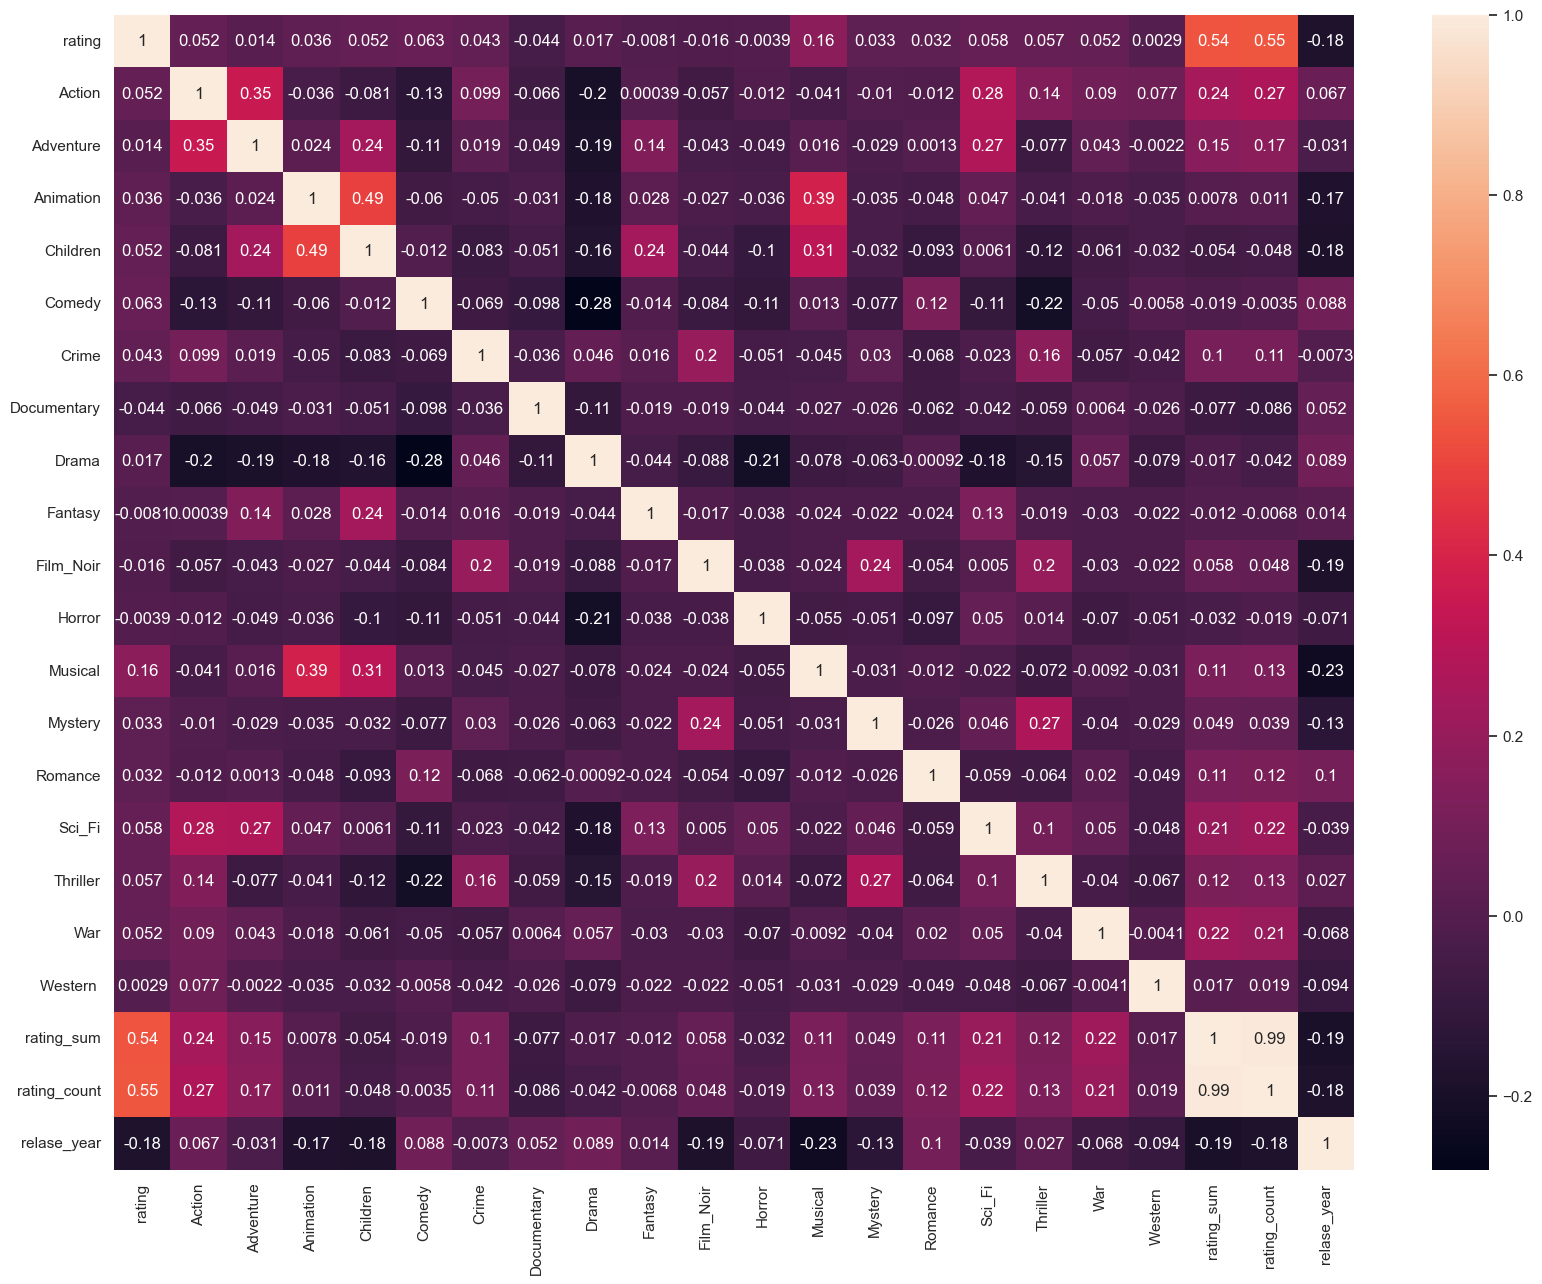

In [28]:
cols = ['rating', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'War', 'Western ', 'rating_sum', 'rating_count',
       'relase_year']
sns.set(rc = {'figure.figsize':(20,15)})
hm = sns.heatmap(df_rating[cols].corr(),
                 cbar=True,
                 annot=True)

#### Первый вывод, который позволяет сделать изучение данных корреляционного анализа: среди детских фильмов много анимационных и музыкальных. Неплохо, конечно, но об этом можно было бы догадаться и без всякого корреляционного анализа, да и к повадкам юзера-405 информация никакого отношения не имеет.

#### **Из наиболее выраженных предпочтений юзера-405 можно называть любовь к музыке. Несколько консервативен, предпочитает старые фильмы более новым. Равнодушен к ковбоям, фэнтези и жанру хоррор. Документалистику и "чернуху" не любит. Но, в целом, в оценке фильмов старается быть объективным и, возможно, занимается этим профессионально.**

#### _И плохая новость: наличие практически полной [коллинеарности](https://ru.wikipedia.org/wiki/Мультиколлинеарность#:~:text=Мультиколлинеарность%20(multicollinearity)%20—%20в%20эконометрике,наличие%20сильной%20корреляции%20между%20факторами) между rating_sum и rating_count. Эти два показателя по природе своей находятся в функциональной линейной зависимости, а значит, у нашей модели ожидаются проблемы со сходимостью._

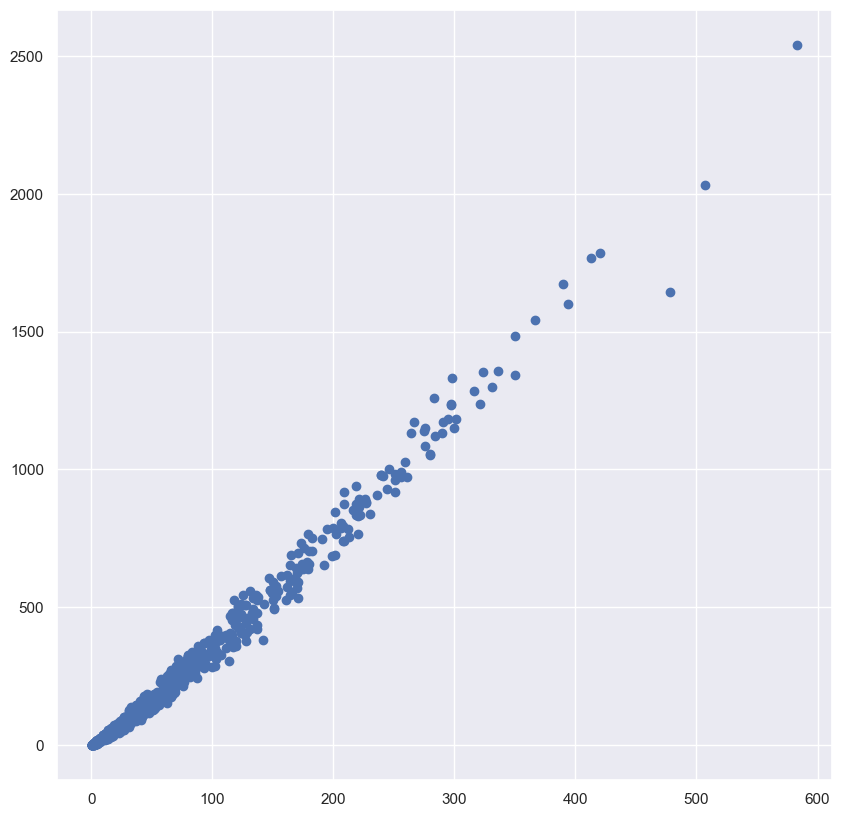

In [29]:
plt.figure(figsize=(10,10)) # График соответствия rating_count и rating_sum
plt.scatter(df_rating[['rating_count']], df_rating[['rating_sum']]);
plt.grid(True)

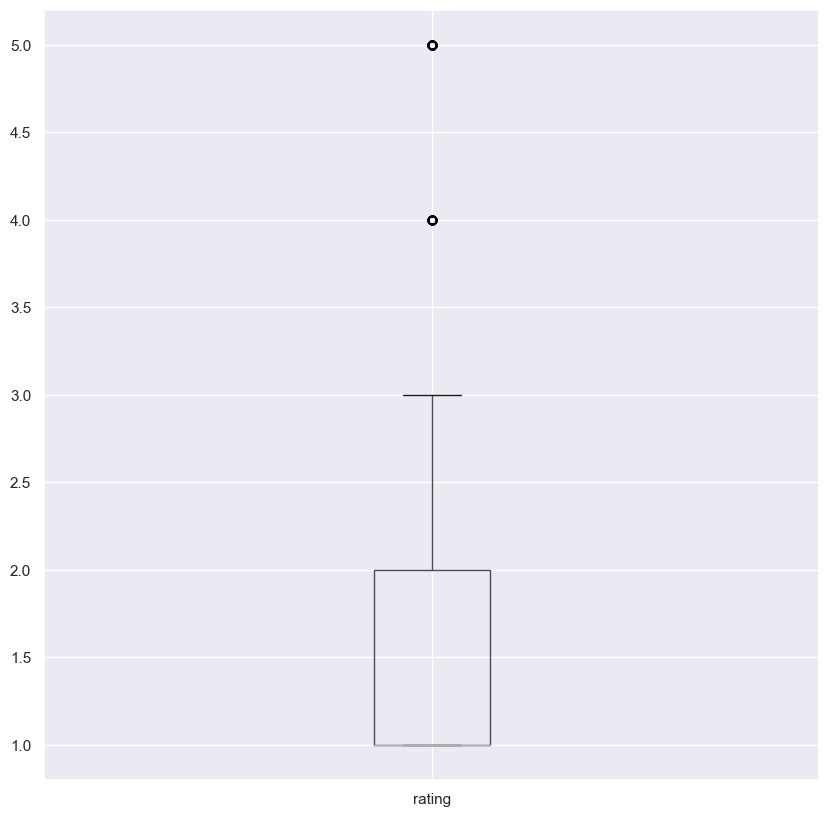

In [30]:
plt.figure(figsize=(10,10))
df_rating.boxplot(column='rating'); # Статистическое распределение оценок юзера-405.

In [31]:
df_rating['rating'].groupby(df_rating['rating']).count() # То же самое, в абсолютных величинах

rating
1    485
2     73
3     63
4     48
5     68
Name: rating, dtype: int64

#### **Юзер-405 строгий критик. Более половины оцененой им фильмографии с его точки зрения вообще не кино. На этом фоне оценки "хорошо" и "отлично" никакие не оценки вовсе, а статистические выбросы.**

### Вот, пожалуй, всё, что можно сказать. Вернёмся к построению регрессионной модели.

## Построим и обучим модель

### 2.5. Сформируем обучающую и тестовую выборки

In [32]:
X, y = df_rating[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western ', 'rating_sum', 'rating_count', 'relase_year']], df_rating['rating']

### 2.6. Обучение модели

#### 2.6.1. Логистическая регрессия

In [33]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, y, test_size=0.2)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression(max_iter=5000) # Без весьма значительного увеличения количества итераций модель не сходится, чего и следовало ожидать

In [36]:
model.fit(X_train_l, y_train_l)

LogisticRegression(max_iter=5000)

#### 2.6.2. Деревья решений
Оценка фильма представляет собой категориальную переменную, значит эта модель применима.

In [37]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.2)

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
model = DecisionTreeClassifier()

In [40]:
model.fit(X_train_t, y_train_t)

DecisionTreeClassifier()

### 2.7. Оценим качество

In [41]:
from sklearn.metrics import accuracy_score

#### 2.7.1. Логистическая регрессия

In [42]:
# Оцениваем качество на выборке для обучения
accuracy_score(y_train_l, model.predict(X_train_l))

0.9168081494057725

In [43]:
# Оцениваем качество на выборке для тестирования
accuracy_score(y_test_l, model.predict(X_test_l))

0.8918918918918919

#### 2.7.2. Деревья решений

In [44]:
# Оцениваем качество на выборке для обучения
accuracy_score(y_train_t, model.predict(X_train_t))

0.9966044142614601

In [45]:
# Оцениваем качество на выборке для тестирования
accuracy_score(y_test_t, model.predict(X_test_t))

0.5743243243243243

#### Итак, **выводы**. Модель логистической регрессии ни в какую не желала сходится (хотя и очень старалась), что объясняется подбором предикторов: из rating_sum и rating_count один показатель, вожможно, избыточный. Модель DecisionTreeClassifier демонстрирует признаки переобучения: доля верных предсказаний для обучающей выборки достигает практически 1, но на тестовой выборке падает вдвое.

***

## Линейная регрессия, как ей и положено было бы быть для **небинарного регрессора**:

In [46]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2)

In [47]:
# Импортируем модуль линейной регрессии
from sklearn.linear_model import LinearRegression

In [48]:
model_lr = LinearRegression()

In [49]:
model_lr.fit(X_train_lr, y_train_lr)

LinearRegression()

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error (y_train_lr, model_lr.predict(X_train_lr))

1.2096650597147147

In [52]:
mean_squared_error (y_test_lr, model_lr.predict(X_test_lr))

1.1071487469638361

### с исключением rating_count

In [53]:
X0_lr, y0_lr = df_rating[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western ', 'rating_sum', 'relase_year']], df_rating['rating']

In [54]:
X0_train_lr, X0_test_lr, y0_train_lr, y0_test_lr = train_test_split(X0_lr, y0_lr, test_size=0.2)

In [55]:
model0_lr = LinearRegression()

In [56]:
model0_lr.fit(X0_train_lr, y0_train_lr)

LinearRegression()

In [57]:
mean_squared_error (y0_train_lr, model0_lr.predict(X0_train_lr))

1.2083676256998754

In [58]:
mean_squared_error (y0_test_lr, model0_lr.predict(X0_test_lr))

1.2195964331867426

### сделалось хуже

***

### **Проверим, к чему приведёт исключение из параметров модели, допустим, показателя rating_count:**

In [59]:
X0, y0 = df_rating[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western ', 'rating_sum', 'relase_year']], df_rating['rating']

#### Логистическая регрессия:

In [60]:
X0_train_l, X0_test_l, y0_train_l, y0_test_l = train_test_split(X0, y0, test_size=0.2)

In [61]:
model0 = LogisticRegression(max_iter=1000) # Итераций требуется существенно меньше

In [62]:
model0.fit(X0_train_l, y0_train_l)

LogisticRegression(max_iter=1000)

In [63]:
# Оцениваем качество на выборке для обучения
accuracy_score(y0_train_l, model0.predict(X0_train_l))

0.6926994906621392

In [64]:
# Оцениваем качество на выборке для тестирования
accuracy_score(y0_test_l, model0.predict(X0_test_l))

0.6621621621621622

#### Деревья решений:

In [65]:
X0_train_t, X0_test_t, y0_train_t, y0_test_t = train_test_split(X0, y0, test_size=0.2)

In [66]:
model1 = DecisionTreeClassifier()

In [67]:
model1.fit(X0_train_t, y0_train_t)

DecisionTreeClassifier()

In [68]:
# Оцениваем качество на выборке для обучения
accuracy_score(y0_train_t, model1.predict(X0_train_t))

0.99830220713073

In [69]:
# Оцениваем качество на выборке для тестирования
accuracy_score(y0_test_t, model1.predict(X0_test_t))

0.5067567567567568

### Чуда не произошло, а исключение предиктора rating_count только ухудшило качество предсказания, хотя и положительно сказалось на сходимости модели.
### Впрочем, **для прикладных целей точность предсказания, полученная с использованием модели логистической регрессии, более чем достаточна.**

## **Spark**

### 2.8. Загрузить данные в spark

In [70]:
spark_rating = spark.read.csv('/home/sk27/learning/BIG_DATA/bd_project_work/part_1/ml-100k/data/rating.csv', sep = '\t', inferSchema=True, header=True)

In [71]:
spark_rating.show()

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|    196|    242|     3|881250949|
|    186|    302|     3|891717742|
|     22|    377|     1|878887116|
|    244|     51|     2|880606923|
|    166|    346|     1|886397596|
|    298|    474|     4|884182806|
|    115|    265|     2|881171488|
|    253|    465|     5|891628467|
|    305|    451|     3|886324817|
|      6|     86|     3|883603013|
|     62|    257|     2|879372434|
|    286|   1014|     5|879781125|
|    200|    222|     5|876042340|
|    210|     40|     3|891035994|
|    224|     29|     3|888104457|
|    303|    785|     3|879485318|
|    122|    387|     5|879270459|
|    194|    274|     2|879539794|
|    291|   1042|     4|874834944|
|    234|   1184|     2|892079237|
+-------+-------+------+---------+
only showing top 20 rows



### 2.9. Средствами спарка вывести среднюю оценку для каждого фильма

In [72]:
spark_rating_avg = spark_rating.groupby('item_id').avg().drop('avg(user_id)', 'avg(item_id)', 'avg(timestamp)') # Агрегируем и удаляем лишнее
spark_rating_avg = spark_rating_avg.withColumn('avg(rating)', func.round(spark_rating_avg['avg(rating)'], 2)).sort(col('item_id')) # Округлим результат до двух знаков и отсортируем

In [73]:
spark_rating_avg.show()

+-------+-----------+
|item_id|avg(rating)|
+-------+-----------+
|      1|       3.88|
|      2|       3.21|
|      3|       3.03|
|      4|       3.55|
|      5|        3.3|
|      6|       3.58|
|      7|        3.8|
|      8|        4.0|
|      9|        3.9|
|     10|       3.83|
|     11|       3.85|
|     12|       4.39|
|     13|       3.42|
|     14|       3.97|
|     15|       3.78|
|     16|       3.21|
|     17|       3.12|
|     18|        2.8|
|     19|       3.96|
|     20|       3.42|
+-------+-----------+
only showing top 20 rows



### 2.10. Посчитайте средствами spark'a среднюю оценку для каждого жанра

Подготовим данные:

In [74]:
spark_movies = spark.read.csv('/home/sk27/learning/BIG_DATA/bd_project_work/part_1/ml-100k/data/movies.csv', sep = '|', inferSchema=True, header=True)\
.drop('movie_title', 'release_date', 'video_release_date', 'url', 'unknown')
spark_mr = spark_rating.join(spark_movies, spark_movies.movie_id == spark_rating.item_id, 'inner').drop('timestamp', 'movie_id') # Сджойним и удалим лишнее
spark_mr.show()

+-------+-------+------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+--------+
|user_id|item_id|rating|Action|Adventure|Animation|Children|Comedy|Crime|Documentary|Drama|Fantasy|Film_Noir|Horror|Musical|Mystery|Romance|Sci_Fi|Thriller|War|Western |
+-------+-------+------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+--------+
|    196|    242|     3|     0|        0|        0|       0|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|       0|  0|       0|
|    186|    302|     3|     0|        0|        0|       0|     0|    1|          0|    0|      0|        1|     0|      0|      1|      0|     0|       1|  0|       0|
|     22|    377|     1|     0|        0|        0|       1|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|   

#### 2.10.1. Вариант 1 (лёгкий)

In [75]:
pdf = pd.DataFrame({'genre': 'range'}, index = [0])
result= spark.createDataFrame(pdf)  # Создадим пустой dataframe, чтобы было куда поместить
for genre in ('Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
              'Sci_Fi', 'Thriller', 'War', 'Western '):
    genre_rating = spark_mr.groupby(genre).avg().filter(spark_mr[genre] == 1).select('avg(rating)').withColumnRenamed('avg(rating)', genre)  # Агрегируем, обрабатываем, отбираем нужное
    genre_rating = genre_rating.withColumn(genre, func.round(genre_rating[genre], 2)) # Округляем до двух знаков
    result = result.join(genre_rating) # Джойним к итогам результаты выполнения шага цикла
result = result.drop('genre') # Убираем лишнее для вывода данных на экран
result.show()

+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+----+--------+
|Action|Adventure|Animation|Children|Comedy|Crime|Documentary|Drama|Fantasy|Film_Noir|Horror|Musical|Mystery|Romance|Sci_Fi|Thriller| War|Western |
+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+----+--------+
|  3.48|      3.5|     3.58|    3.35|  3.39| 3.63|       3.67| 3.69|   3.22|     3.92|  3.29|   3.52|   3.64|   3.62|  3.56|    3.51|3.82|    3.61|
+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+----+--------+



#### 2.10.1. Вариант 2 (тяжёлый)

In [76]:
pdf_2 = pd.DataFrame({'genre': '', 'range': ''}, index = [0])
result_2= spark.createDataFrame(pdf_2) # Создадим пустой dataframe
for genre in ('Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
              'Sci_Fi', 'Thriller', 'War', 'Western '):
    genre_rating_2 = spark.createDataFrame(spark_mr.where(spark_mr[genre] == 1).collect()) # Отберём фильмы одного жанра
    genre_rating_2 = genre_rating_2.groupby(genre).avg().withColumn(genre, func.regexp_replace(genre, '1', genre)).select(genre, 'avg(rating)') # Агрегируем, обрабатываем, отбираем нужное
    genre_rating_2 = genre_rating_2.withColumn('avg(rating)', func.round(genre_rating_2['avg(rating)'], 2)) # Округляем до двух знаков
    result_2 = result_2.union(genre_rating_2) # Присоединяем к итогам результаты выполнения шага цикла
result_2 = result_2.filter("genre != ''") # Удалим пустые строки
result_2.show()

+-----------+-----+
|      genre|range|
+-----------+-----+
|     Action| 3.48|
|  Adventure|  3.5|
|  Animation| 3.58|
|   Children| 3.35|
|     Comedy| 3.39|
|      Crime| 3.63|
|Documentary| 3.67|
|      Drama| 3.69|
|    Fantasy| 3.22|
|  Film_Noir| 3.92|
|     Horror| 3.29|
|    Musical| 3.52|
|    Mystery| 3.64|
|    Romance| 3.62|
|     Sci_Fi| 3.56|
|   Thriller| 3.51|
|        War| 3.82|
|   Western | 3.61|
+-----------+-----+



### 2.11. В spark'e получить 2 датафрейма с 5-ю самыми популярными и самыми непопулярными фильмами.

#### 2.11.1. top-5 самых популярных фильмов по сумме оценок

In [77]:
spark_max_sum = spark_mr.groupby('item_id').sum().select('item_id', 'sum(rating)')
spark_max_sum.orderBy(func.col('sum(rating)').desc(), func.col('item_id')).limit(5).show()

+-------+-----------+
|item_id|sum(rating)|
+-------+-----------+
|     50|       2541|
|    100|       2111|
|    181|       2032|
|    258|       1936|
|    174|       1786|
+-------+-----------+



#### 2.11.2. top-5 самых популярных фильмов по количеству оценок

In [78]:
spark_max_cnt = spark_mr.groupby('item_id').count()
spark_max_cnt.orderBy(func.col('count').desc(), func.col('item_id')).limit(5).show()

+-------+-----+
|item_id|count|
+-------+-----+
|     50|  583|
|    258|  509|
|    100|  508|
|    181|  507|
|    294|  485|
+-------+-----+



**И она, всё та же боль: как выбрать top-N объектов, если заданному критерию отбора соответствует более, чем N объектов?**

Отберём по id, например.

#### 2.11.3. top-5 самых непопулярных фильмов по сумме оценок

In [79]:
spark_min_sum = spark_mr.groupby('item_id').sum().select('item_id', 'sum(rating)')
spark_min_sum.orderBy(func.col('sum(rating)'), func.col('item_id')).limit(5).show()

+-------+-----------+
|item_id|sum(rating)|
+-------+-----------+
|    599|          1|
|    830|          1|
|    852|          1|
|   1309|          1|
|   1320|          1|
+-------+-----------+



#### 2.11.4. top-5 самых непопулярных фильмов по количеству оценок

In [80]:
spark_min_cnt = spark_mr.groupby('item_id').count()
spark_min_cnt.orderBy(func.col('count'), func.col('item_id')).limit(5).show()

+-------+-----+
|item_id|count|
+-------+-----+
|    599|    1|
|    677|    1|
|    711|    1|
|    814|    1|
|    830|    1|
+-------+-----+



## **III. Теоретическая часть**

Задача - разработать стратегию внедрения хранилища данных и работы с большими данными в интернет-кинотеатре.

### 3.1. Описание основных бизнес-отчётов

1. **Отчёт о состоянии работы онлайн-кинотеатра за период** (в сравнении с сопоставимым предыдущим периодом) с отражением количества заключённых договоров аренды фильмов по жанрам и году релиза, местам проживания клиентов, продавцам, а также полученной выручки. Отчёт реализует дескриптивную и диагностическую аналитику, описывая текущее положение дел, существующие тенденции и позволяет установить направленность и причины происходящих изменений.

2. **Отчёт об ожидаемых результатах работы онлайн-кинотеатра на следующий период** при условии, что существующие подходы к ведению дел останутся неизменны. Прогноз реализует предиктивную аналитику, описывая предполагаемое состояние бизнеса на основании экстраполяции накопленной информации.

3. **Отчёт о перспективных направлениях повышения эффективности работы** по продвижению онлайн-кинотеатра на рынке, например повышению мотивации клиентов путём таргетинга предложения по регионам проживания, жанрам фильмов и их рейтингу (а кто сказал, что рейтинг должен формироваться пользователями?). Отчёт реализует предписывающую аналитику, определяя пути развития бизнеса с позиции роста объёма продаж услуг.


### 3.2. Описать основные имеющиеся данные и источники их поступления

**1. Таблицы измерений:**
* справочники language, country, city формируются на основани внешних данных, имеющихся в открытом доступе в сети Интернет;
* данные о клиентах customer можно получить от сторонней организации, располагающей такого рода информацией (исключительно в рамках действующего законодательства, разумеется!), а можно собирать в процессе предоставления услуг. Наиболее эффективно комбинорование этих двух способов получения информации.
* данные о продавцах staff проще и удобнее всего получить от продавцов,хотя можно обратиться и в частное детективное агенство, например. Или в ФСБ. Но лучше от продавцов;
* данные о фильмах, подобно данным о клиентах, наиболее эффективно получать, собирая информацию из сети Интернети обогащая её собственной информацией;

**2. Таблицы фактов** rental и payment наполняются собственной информацией в процессе функционирования онлайн-кинотеарта.

### 3.3. Описать основные сущности в хранилище данных и процесс заливки данных

**[Файл Google Docs](https://docs.google.com/document/d/1Q9iwAT0TxbOKiODS7sTl5sQq7PdZnCYmdirkWmJLJKs/edit?usp=sharing)**

**[Free Diagram](https://app.quickdatabasediagrams.com/#/d/0ugFjq)**

In [81]:
display(Image(url='https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1IJdGHKXoYW2LFTgHuX5mHVWDkfZKaWoh'))

#### 3.3.1. Описание сущностей
**rental**
основная сущность, хранящая информацию об аренде фильмов клиентом. Первичный суррогатный ключ rental_id идентифицирует каждую покупку (аренду) фильма. Идентификатор фильма film_id указывает на фильм (информация о котором хранится в соответствующей таблице). Атрибуты rental_date и return_date содержат информацию о дате и времени начала и окончания аренды фильма, а поле last_update - о дате и времени последнего обновления информации. Атрибуты customer_id и staff_id идентифицируют покупателя (клиента) и продавца, совершившего сделку.

**films**
информация о фильмах. Суррогатный первичный ключ film_id уникален, как и положено первичному ключу. Атрибут title содержит название фильма, а description описание перипетий его сюжета. Кроме того, информация о фильме включает сведения о его продолжительности (duration), годе релиза (relase_year), идентификаторе оригинального языка фильма language_id и его рейтинге rating. Атрибут activebool хранит булеву информацию о доступности фильма для аренды на момент последних изменений информации last_update.

**payment**
сведения о платежах. Помимо ставшего уже традиционным суррогатного ключа payment_id, сущность содержит информацию об оплате аренды фильмов: идентификатор аренды (обеспечивающий связь с таблицей rental), величина платежа amount, его дата и время payment_date. Хранится информация о продавце, принявшем платёж staff_id (это не обязательно тот же продавец, который заключил сделку аренды), а также, в целях полноты и достоверности данных и повышения удобства их обработки, о клиенте (customer_id).

**customer**
сведения о клиентах. Клиент - наше всё, он источник всех наших благосостояний, пассажира клиента надо любить (как минимум, делать вид, будто). Хранится информация об имени клиента (name), идентификаторах родного или предпочитаемого языка (language_id), страны (country_id) и города (city_id) проживания. Актуальна была бы информация и о поле клиента (sex), но добавить соответствующий атрибут я забыл, а переделывать ещё раз схему ужасно не хочется. Давайте представим, что это поле там есть, ладно? Обеспечена возможность хранить информацию об адресе проживания (address) и адресе электронной почты (email), актуальности лица как заказчика (activebool), дате и времени создания карточки клиента (creat_date) и последнего обновления информации (last_update).

**staff**
сведения о продавцах. Аналогичны сведениям о клиентах, с поправкой на тот несомненный факт, что продавец - не наше всё. Впрочем, на практике это выражается в том лишь, что хранение информации о предпочитаемом продавцом языке не поддерживается.

**country**
справочник стран.

**city**
справочник городов.

**language**
справочник языков.

_Во всех сущностях предусмотрено необязательное строковое поле note, в котором может быть отражена справочная или дополнительная информация о записи._


#### 3.3.2. Описание процесса заливки данных.

**сбор данных**

на первом этапе оператор (желательно, выпускник “Нетологии”) получает данные из источника. Сбор информации является очень важным этапом в процессе наполнения базы данных, так как, ошибки, допущенные на этом этапе, почти невозможно исправить. В случае, если сбор информации трудно или нецелесообразно автоматизировать, её извлечение осуществляется вручную. Получение информации для формирования справочников language, country, city затруднений не вызывает. Сведения о продавцах вообще получаем от самих продавцов. Творческий подход необходим при формировании справочника фильмов films - фактические данные о фильмах, такие как описание, жанр, год релиза, актёрский состав и т.п. можно получить вместе с фильмом (мы же не торгуем пиратскими копиями!), а можно получить в сети Интернет вручную или парсингом соответствующих ресурсов (или торгуем?).

**преобразование данных**

преобразование данных может состоять из нескольких процедур, изменяющих формат данных. Формат устанавливается базой данных, то есть описываются допустимые символы и некоторые ограничения – правила, которыми следует руководствоваться для того, чтобы при загрузке не возникло как синтаксических, так и семантических проблем. 
Получив данные из источника, оператор преобразует, если это необходимо, их в приемлемую форму. Преобразование заключается в приведении в установленный формат для данного типа данных. В результате преобразования должны получиться данные, которые недвусмысленны, полны, правильны и согласованы между собой. А именно: данные являются правильными, если значения и описания отражают связанный с ними объект безошибочно и точно. Например, название города в таблице city должно быть приведено на английском языке в соответствии с традицией англоязычных стран (Пекин - Beijing). Недвусмысленность данных подразумевает то, что если информацию можно растолковать несколькими способами, то в результате её обработки необходимо добавить некоторый отличительный признак, чтобы разрешить неоднозначность: город London в Британии следует каким-то образом отграничить от города London в Канаде.  Данные находятся в согласованном состоянии, если они удовлетворяют единой схеме обозначений, формату. Данные отвечают требованию полноты, если, во-первых, все значения данных определены для каждого объекта, возможно, за исключением информации, верное значение которой неизвестно на данный момент, а, во-вторых, общее число записей в данных совпадает с необходимым количеством и ни одна запись не потеряна.
Обработанные данные целесообразно сохранить в файлы на локальном компьютере и переносить в базу данных после окончательной проверки.

**загрузка данных**

первичную загрузку данных производим из сформированных на предыдущем этапе файлов в соответствии с правилами используемой СУБД. Первоначально загружаем справочники, чтобы избежать конфликта внешних ключей. Объём загружаемой информации в нашем случае сравнительно невелик, и при должной внимательности и осмотрительности проблем у выпускника “Нетологии” вызвать не должен. 

### 3.4. Описать основные проверки на качество данных (10 штук), которыми будем пользоваться при заливке

* проверка на уникальность всех первичных ключей (формат данных int предполагает, что значение ключей задаётся вручную);
* во всех сущностях значения атрибутов rental_date, return_date, creat_date, payment_date и last_update должно иметь формат timestamp;
* в таблицах customer и staff значение поля creat_date не может быть больше значения поля last_update;
* в таблицах customer и staff атрибут name не может быть пустым;
* в таблице rental значение поля return_date строго больше значения поля rental_date;
* название стран, языков и городов в соответствующих справочниках должно быть указано на английском языке в соответствии с общепринятыми правилами написания;
* значение атрибута email в соответствующих таблицах должно соответствовать шаблону %@%.%;
* значение атрибута title в сущности films не может быть пустым;
* значение атрибута sex в соответствующих сущностях может принимать только значения male и female, никакого гендерного разнообразия нам тут не нужно;
* значение атрибута rating в таблице films не может быть меньше 1 и больше 5.

### 3.5. Data-проект, который должен улучшить показатели бизнеса, структурированный по Crisp-DM

**[Файл Google Docs](https://docs.google.com/document/d/1Pu1nQxXg1_YyCviPb13FHB2M4nH-yd4Poq470TlhCHY/edit?usp=sharing)**

#### **Необходимо построить систему управления рейтингами фильмов в онлайн-кинотеатре.**

Мотивация клиента к совершению сделки обеспечивается, помимо прочего, значением показателя рейтинга фильма. Предполагается, что рейтинг фильма отражает некоторую усреднённую его оценку теми зрителями, которые уже имели счастье (или несчастье) фильмом насладиться. Помимо того, кажется очевидным, что зритель отдаст предпочтение фильму с более высоким рейтингом. Предполагается и кажется очевидным, но…
Это работает именно так лишь в том случае, если рейтинг — единственный фактор, влияющий на принятие клиентом решения. В реальности клиенты живые люди, и на их мотивацию, помимо рейтинга, существенное влияние оказывает, например, жанр фильма, год его релиза, состав актёров, музыка, качество перевода (если фильм демонстрируется не на языке оригинала) и т.п.
Если влиять на прочие, помимо рейтинга, характеристики фильма невозможно или практически невозможно (например, нельзя изменить актёрский состав, но можно выбрать более качественный перевод), то рейтинг - тот параметр, которому вполне можно несколько “помочь” принять более удобное для бизнеса значение, не дожидаясь оценки клиентов. Ведь, в конце концов, для них же стараемся, для их же пользы!
Ну, и для нашей, конечно…

**Понимание бизнес-целей (Business Understanding)**

Предположим, имеется клиент со своими радостями и болью, вкусами и предпочтениями. В случае близкого к оптимальному сочетанию значения показателей: любимый жанр, любимый актёр, и т.д., а также высокий рейтинг - степень конверсии высока. Но такие фильмы рано или поздно кончатся.
И останутся фильмы, жанры, допустим, которых клиенту в той или иной степени интересны. Нужно присвоить фильмам такие значения рейтингов, чтобы мотивировать клиента купить максимальное количество фильмов из всего предлагаемого ассортимента.
 
_Итак, сформулируем **цель проекта**: на основании имеющихся данных о ранее совершённых сделках построить модель управления рейтингами фильмов в онлайн-кинотеарте таким образом, чтобы сочетание рассчитанных значений рейтинга с другими характеристиками фильма обеспечило максимизацию конверсии продаж._
 
В качестве основной метрики целесообразно использовать количество совершённых сделок ранее зарегистрированными клиентами. Другие элементы этапа: организация использования полученной модели, требования к минимально необходимому её качеству, оценка ожидаемого эффекта и трудозатрат зависят от фактического состояния нашего бизнеса.


**Начальное изучение данных (Data Understanding)**

Начинаем реализацию проекта и для начала смотрим на данные. На этом шаге никакого моделирования нет, используется только описательная аналитика.
В нашем случае задача упрощается тем, что для реализации проекта используются только собственные данные, формирующиеся в ходе работы нашего онлайн-кинотеатра.
С помощью графиков и таблиц исследуем и при необходимости описываем данные, чтобы сформулировать гипотезы относительно того, как эти данные помогут решить задачу. Если данных слишком много для используемого ПО, создаём симпл данных.
Изучаем качество данных: пропуски, несоответствие формата данных, ошибки (опечатки), неконсистентная кодировка значений (конечно, этого всего в собственных данных быть не должно, но это не точно).

**Подготовка данных (Data Preparation)**

Подготовка данных – это традиционно наиболее затратный по времени этап machine learning проекта. Цель этапа – подготовить обучающую выборку для использования в моделировании.
Осуществляем отбор данных, имеющих отношение к решаемой задаче. Решаем: какова релевантность атрибута (например, имя клиента или email вряд ли окажутся полезны; а страна и город проживания, ранее приобретённые фильмы, срок регистрации на портале онлайн-кинотеатра - хорошие, годные атрибуты. Пол, возраст также могут быть полезны для построения модели, но малопригодны для последующего таргетинга, тут надо подумать), достаточно ли качественный атрибут для использования в модели (если много пропусков — попытаться восполнить данные или не использовать атрибут вовсе?), стоит ли использовать коррелирующие друг с другом атрибуты, возможно ли использовать атрибут в соответствии с законодательством или политикой компании (персональные данные клиентов, например).
Очищаем данные: заполняем или удаляем пропуски, исправляем или удаляем ошибки, исправляем кодировку и формат данных (конечно, этого всего в собственных данных быть не должно, но …).

**Моделирование (Modeling)**

* выбираем алгоритм;
* планируем тестирование (на каких данных обучать, а на каких тестировать модель);
* обучаем модель (а лучше нескольких моделей). На этом же этапе выясняем, показывает ли модель какие-то интересные закономерности? Какова скорость обучения/применения модели? Были ли проблемы с качеством данных?
* оцениваем результаты моделирования с технической точки зрения: нужно ли изменение модели или выбор наиболее релевантной модели из ранее обученных(если критерий успеха не достигнут, то можно либо улучшать текущую модель, либо пробовать новую). На этом этапе нужно оценить, готова ли модель к внедрению, достигаются ли заданные критерии качества.

**Оценка (Evaluation)**

Результатом предыдущего шага является построенная математическая модель (model), а также найденные закономерности (findings). На пятом шаге мы оцениваем результаты проекта.
* оцениваем результаты моделирования с точки зрения достижения бизнес-целей, формулируем результат в бизнес-терминах. Выясняем, насколько хорошо полученные результаты решают бизнес-задачу, найдена ли какая-то новая ценная информация, которую стоит выделить отдельно?
* принимаем решение: внедрять или улучшать модель?

**Внедрение (Deployment)**

На данном шаге осуществляется внедрение модели. Причем под внедрением может пониматься как физическое добавление функционала, так и инициирование изменений в бизнес-процессах компании.
* планируем развёртывание: что и в каком виде будем внедрять, как внедрение модели будет выглядеть для пользователя, уясняем принципы мониторинга результатов работы модели;
* настраиваем мониторинг решения (если предусмотрен): какие показатели и в каком виде будем отслеживать, как понять, что модель устарела, и если устарела — переобучать или разрабатывать новую?
* пишем отчёт по результатам моделирования.

### 3.6. Описать требуемые роли в команде по работе с данными на этапах 3.4 и 3.5

Предполагается, что дальше речь пойдёт о ролях а не об отдельных сотрудниках, т.е. разный функционал может выполнять одно и то же лицо, обладающее соответствующими знаниями и навыками.

Для проведения проверок данных в соответствии с п. 3.4 необходим Инженер по данным.

Для реализации data-проекта в соответствии с п. 3.5 необходимы:

на этапе _Business Understanding_ в нашем случае будет достаточно одного Аналитика, поскольку цель проекта определена. В противном случае понадобился бы ещё Заказчик проекта (в нашем случае руководитель онлайн-кинотеатра или аналогичное лицо).

на этапе _Data Understanding_ необходим Аналитик и ETL-специалист или просто квалифицированный Аналитик, умеющий работать с БД;

на этапе _Data Preparation_ также необходимы Аналитик (а лучше несколько трудолюбивых аналитиков-выпускников "Нетологии") с умением работать в обычных офисных приложениях и ETL-специалист;

на этапе _Modeling_ при классическом подходе необходим Data Scientist, но в нашем случае можно будет обойтись всё тем же квалифицированным Аналитиком данных;

на этапе _Evaluation_ необходимо привлечь Заказчика (т.е. руководителя, в нашем случае), DS или Аналитика, Продавцов, желательно - Разработчика ПО;

на этапе _Deployment_ необходимы Заказчик, Разработчик, DS-специалист или Аналитик.